# Yaw angle optimisation
Calculating the optimum yaw angle for turbines across a range of wakes and wind speeds

## To do
- Assess difference in speed of calculation and optimal values when using different fidelity for final optimisation
- Increase number of turbines

## Setup

In [22]:
# import libraries
import logging
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pqdm.processes import pqdm
from tqdm.notebook import tqdm

import utils

logging.basicConfig(
    format="%(asctime)s:%(levelname)s:%(message)s",
    datefmt="%H:%M:%S",
    level=logging.INFO,
)

## Baseline values

In [23]:
# extract probabilities for full wind speed/direction range
_, Sector_frequency, P = utils.run_sim(
    wfm=utils.wfm_low,
    x=utils.wt9_x,
    y=utils.wt9_y,
    yaw=0,
    ws=utils.WS_DEFAULT,
    wd=utils.WD_DEFAULT,
)

20:21:58:WARNING:P renormalised as total probability was 0.9997679498494156
20:21:58:WARNING:no reference simulation provided


In [24]:
# drop wind speeds below cut in speed
ind_cut_in = np.argmax(utils.wfm_low.windTurbines.power(utils.WS_DEFAULT) > 0)
ws = utils.WS_DEFAULT[ind_cut_in:]

In [25]:
# run baseline simulations
print("--- Lossless ---")
sim_res_ref_lossless, _, _ = utils.run_sim(
    wfm=utils.wfm_lossless,
    x=utils.wt9_x,
    y=utils.wt9_y,
    yaw=0,
    ws=ws,
    wd=utils.WD_DEFAULT,
    Sector_frequency=Sector_frequency,
    P=P,
    show=True,
)

print("\n--- Low Fidelity ---")
sim_res_ref_low, _, _ = utils.run_sim(
    wfm=utils.wfm_low,
    x=utils.wt9_x,
    y=utils.wt9_y,
    yaw=0,
    ws=ws,
    wd=utils.WD_DEFAULT,
    Sector_frequency=Sector_frequency,
    P=P,
    show=True,
)

print("\n--- High Fidelity ---")
sim_res_ref_high, _, _ = utils.run_sim(
    wfm=utils.wfm_high,
    x=utils.wt9_x,
    y=utils.wt9_y,
    yaw=0,
    ws=ws,
    wd=utils.WD_DEFAULT,
    Sector_frequency=Sector_frequency,
    P=P,
    show=True,
)

20:21:58:WARNING:no reference simulation provided
20:21:58:WARNING:no reference simulation provided
20:21:59:WARNING:no reference simulation provided


--- Lossless ---
Annual energy [GWh]: 82.049
LCoE [USD/MWh]: 42.918
Capacity factor [%]: 52.000

--- Low Fidelity ---
Annual energy [GWh]: 78.081
LCoE [USD/MWh]: 45.100
Capacity factor [%]: 49.485

--- High Fidelity ---
Annual energy [GWh]: 78.556
LCoE [USD/MWh]: 44.827
Capacity factor [%]: 49.786


## Optimise yaw angles

In [26]:
# initialise optimal yaw dataset
coords = {
    "wt": list(sim_res_ref_low.wt.values),
    "wd": list(sim_res_ref_low.wd.values),
    "ws": list(sim_res_ref_low.ws.values),
}
yaw_opt = xr.Dataset(
    data_vars={
        "init": (
            list(coords.keys()),
            np.full([len(x) for x in coords.values()], np.nan),
        ),
        "final": (
            list(coords.keys()),
            np.full([len(x) for x in coords.values()], np.nan),
        ),
    },
    coords=coords,
)

In [27]:
# run optimisations and save output
simulations_in = [
    dict(
        wd=wd_,
        sim_res_ref_low=sim_res_ref_low,
        sim_res_ref_high=sim_res_ref_high,
        Sector_frequency=Sector_frequency,
        P=P,
    )
    for wd_ in sim_res_ref_low.wd.values
]
simulations_out = pqdm(
    array=simulations_in,
    function=utils.optimise_direction,
    n_jobs=int(0.75 * os.cpu_count()),
    argument_type="kwargs",
)
for input, (yaw_opt_init, yaw_opt_final) in tqdm(
    zip(simulations_in, simulations_out),
    total=len(simulations_out),
    desc="Saving values to dataset",
):
    yaw_opt["init"].loc[
        :,
        input["wd"],
        :,
    ] = yaw_opt_init
    yaw_opt["final"].loc[
        :,
        input["wd"],
        :,
    ] = yaw_opt_final

QUEUEING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/12 [00:00<?, ?it/s]

Saving values to dataset:   0%|          | 0/12 [00:00<?, ?it/s]

In [28]:
# rerun simulation for optimum
sim_res_opt, _, _ = utils.run_sim(
    wfm=utils.wfm_high,
    x=utils.wt9_x,
    y=utils.wt9_y,
    yaw=yaw_opt.final,
    ws=ws,
    wd=yaw_opt.wd,
    sim_res_ref=sim_res_ref_high,
    Sector_frequency=Sector_frequency,
    P=P,
)

## Overall results

In [29]:
# display comaprison of optimum to baseline
print("--- LCoE ---")
print(f"Lossless [USD/MWh] : {sim_res_ref_lossless.lcoe_overall.values:.3f}")
print(f"Baseline [USD/MWh] : {sim_res_ref_high.lcoe_overall.values:.3f}")
print(f"Optimum [USD/MWh]  : {sim_res_opt.lcoe_overall.values:.3f}")
print(
    f"Recovered [%]      : {100-100*(sim_res_ref_lossless.lcoe_overall.values - sim_res_opt.lcoe_overall.values)/(sim_res_ref_lossless.lcoe_overall.values - sim_res_ref_high.lcoe_overall.values):.2f}"
)
print("\n--- Capacity Factor ---")
print(f"Lossless [%]  : {100*sim_res_ref_lossless.cap_fac_overall.values:.3f}")
print(f"Baseline [%]  : {100*sim_res_ref_high.cap_fac_overall.values:.3f}")
print(f"Optimum [%]   : {100*sim_res_opt.cap_fac_overall.values:.3f}")
print(
    f"Recovered [%] : {100-100*(sim_res_ref_lossless.cap_fac_overall.values - sim_res_opt.cap_fac_overall.values)/(sim_res_ref_lossless.cap_fac_overall.values - sim_res_ref_high.cap_fac_overall.values):.2f}"
)

--- LCoE ---
Lossless [USD/MWh] : 42.918
Baseline [USD/MWh] : 44.827
Optimum [USD/MWh]  : 44.676
Recovered [%]      : 7.89

--- Capacity Factor ---
Lossless [%]  : 52.000
Baseline [%]  : 49.786
Optimum [%]   : 49.954
Recovered [%] : 7.58


## Breakdown results

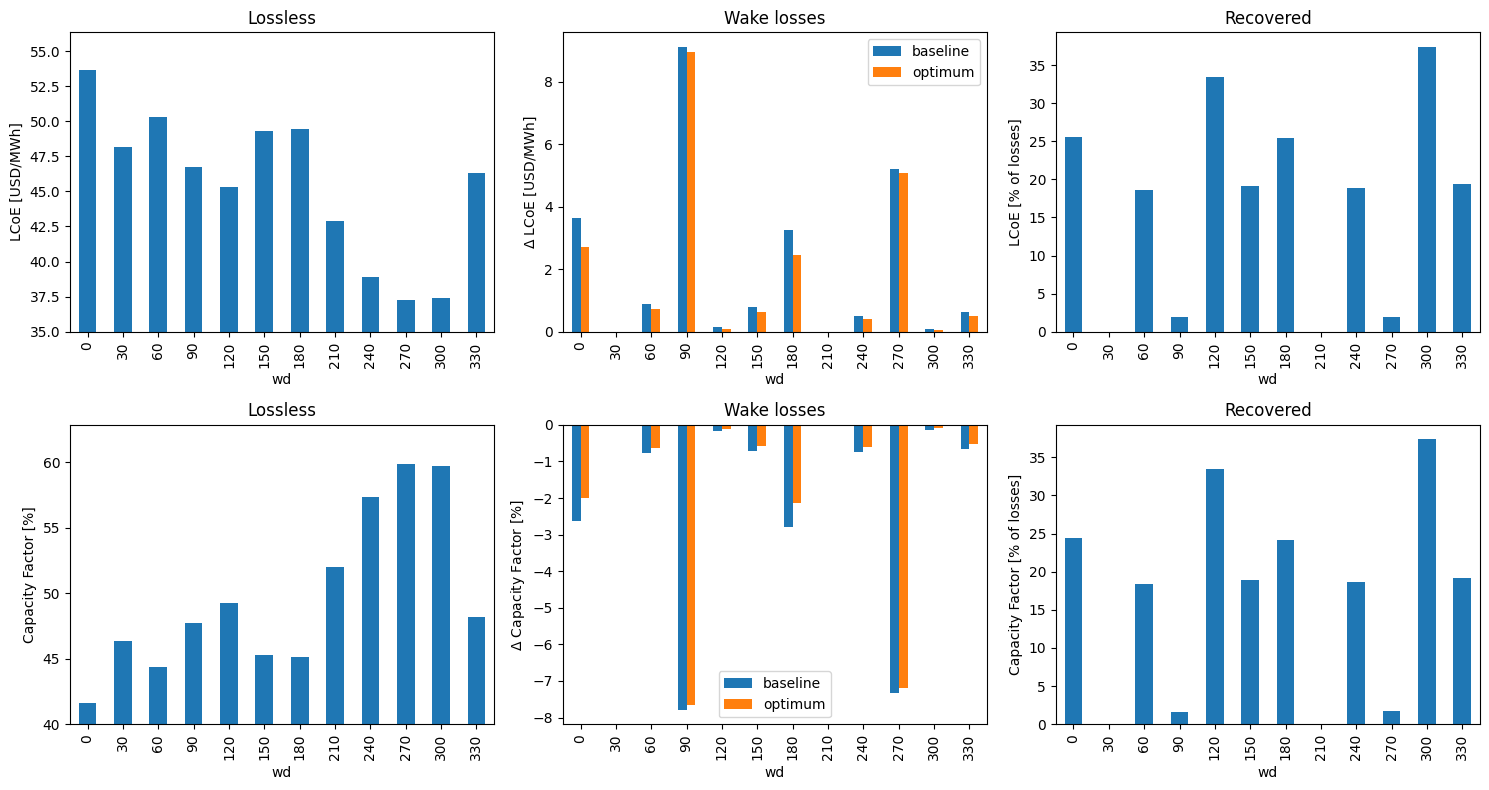

In [30]:
# plot improvements across directions

# initialise
fig, ax_all = plt.subplots(ncols=3, nrows=2, figsize=(15, 8))
lcoe_delta = pd.concat(
    [
        (sim_res_ref_high.lcoe_direction - sim_res_ref_lossless.lcoe_direction)
        .to_series()
        .rename("baseline"),
        (sim_res_opt.lcoe_direction - sim_res_ref_lossless.lcoe_direction)
        .to_series()
        .rename("optimum"),
    ],
    axis=1,
).clip(lower=0)
cap_fac_delta = pd.concat(
    [
        (sim_res_ref_high.cap_fac_direction - sim_res_ref_lossless.cap_fac_direction)
        .to_series()
        .rename("baseline"),
        (sim_res_opt.cap_fac_direction - sim_res_ref_lossless.cap_fac_direction)
        .to_series()
        .rename("optimum"),
    ],
    axis=1,
).clip(upper=0)

# lossless lcoe
sim_res_ref_lossless.lcoe_direction.to_series().plot.bar(ax=ax_all[0, 0])
ax_all[0, 0].set_ylim(
    bottom=math.floor(sim_res_ref_lossless.lcoe_direction.min() / 5) * 5
)
ax_all[0, 0].set_ylabel("LCoE [USD/MWh]")
ax_all[0, 0].set_title("Lossless")
# wake loss lcoe
lcoe_delta.plot.bar(ax=ax_all[0, 1])
ax_all[0, 1].set_ylabel(r"$\Delta$ LCoE [USD/MWh]")
ax_all[0, 1].set_title("Wake losses")
# lcoe recovery
(100 - 100 * lcoe_delta["optimum"] / lcoe_delta["baseline"]).plot.bar(ax=ax_all[0, 2])
ax_all[0, 2].set_ylabel("LCoE [% of losses]")
ax_all[0, 2].set_title("Recovered")

# lossless capacity factor
(100 * sim_res_ref_lossless.cap_fac_direction).to_series().plot.bar(ax=ax_all[1, 0])
ax_all[1, 0].set_ylim(
    bottom=math.floor(100 * sim_res_ref_lossless.cap_fac_direction.min() / 5) * 5
)
ax_all[1, 0].set_ylabel("Capacity Factor [%]")
ax_all[1, 0].set_title("Lossless")
# wake loss capacity factor
(100 * cap_fac_delta).plot.bar(ax=ax_all[1, 1])
ax_all[1, 1].set_ylabel(r"$\Delta$ Capacity Factor [%]")
ax_all[1, 1].set_title("Wake losses")
# capacity factor recovery
(100 - 100 * cap_fac_delta["optimum"] / cap_fac_delta["baseline"]).plot.bar(
    ax=ax_all[1, 2]
)
ax_all[1, 2].set_ylabel("Capacity Factor [% of losses]")
ax_all[1, 2].set_title("Recovered")

fig.tight_layout()

  0%|          | 0/12 [00:00<?, ?it/s]

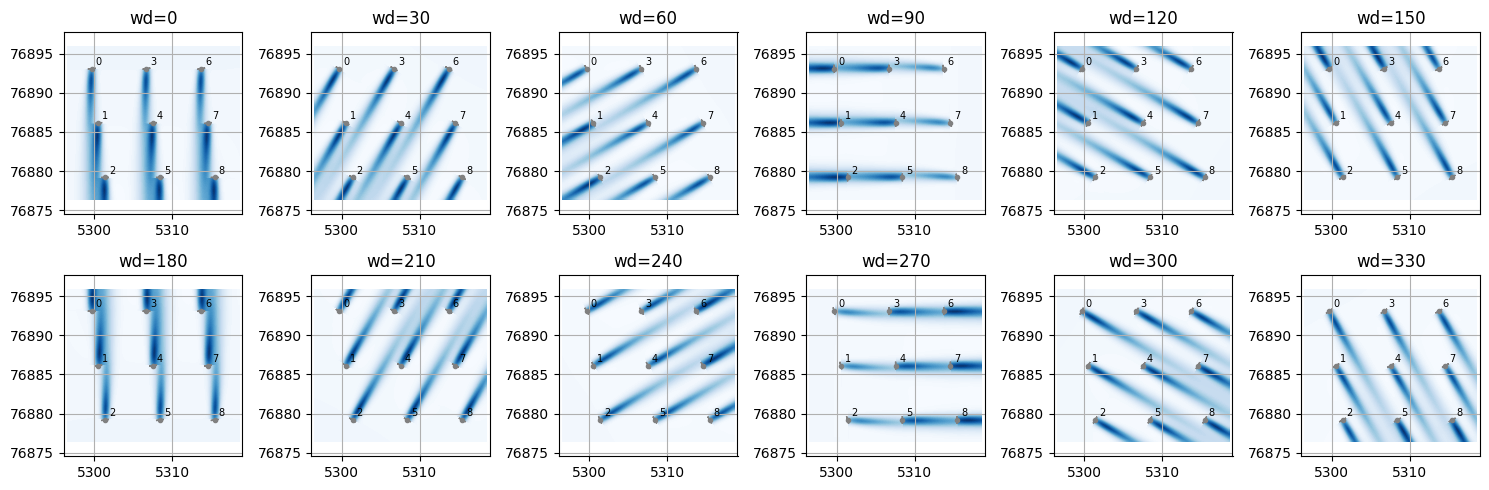

In [31]:
# plot flow maps
fig, ax_all = plt.subplots(ncols=6, nrows=2, figsize=(15, 5))
ws_ = 12
for wd_, ax in tqdm(
    zip(sim_res_ref_high.wd.values, ax_all.flatten()), total=len(sim_res_ref_high.wd)
):
    sim_res, _, _ = utils.run_sim(
        wfm=utils.wfm_high,
        x=utils.wt9_x,
        y=utils.wt9_y,
        yaw=yaw_opt.final.sel(wd=[wd_], ws=ws_),
        ws=ws_,
        wd=[wd_],
        sim_res_ref=sim_res_ref_high.sel(wd=[wd_], ws=ws_),
        Sector_frequency=Sector_frequency,
        P=P,
    )
    fm = sim_res.flow_map()
    fm.plot_wake_map(
        plot_colorbar=False,
        normalize_with=utils.wfm_high.windTurbines.diameter(),
        ax=ax,
    )
    ax.get_legend().remove()
    ax.grid()
    ax.set_title(f"wd={wd_}")

fig.tight_layout()

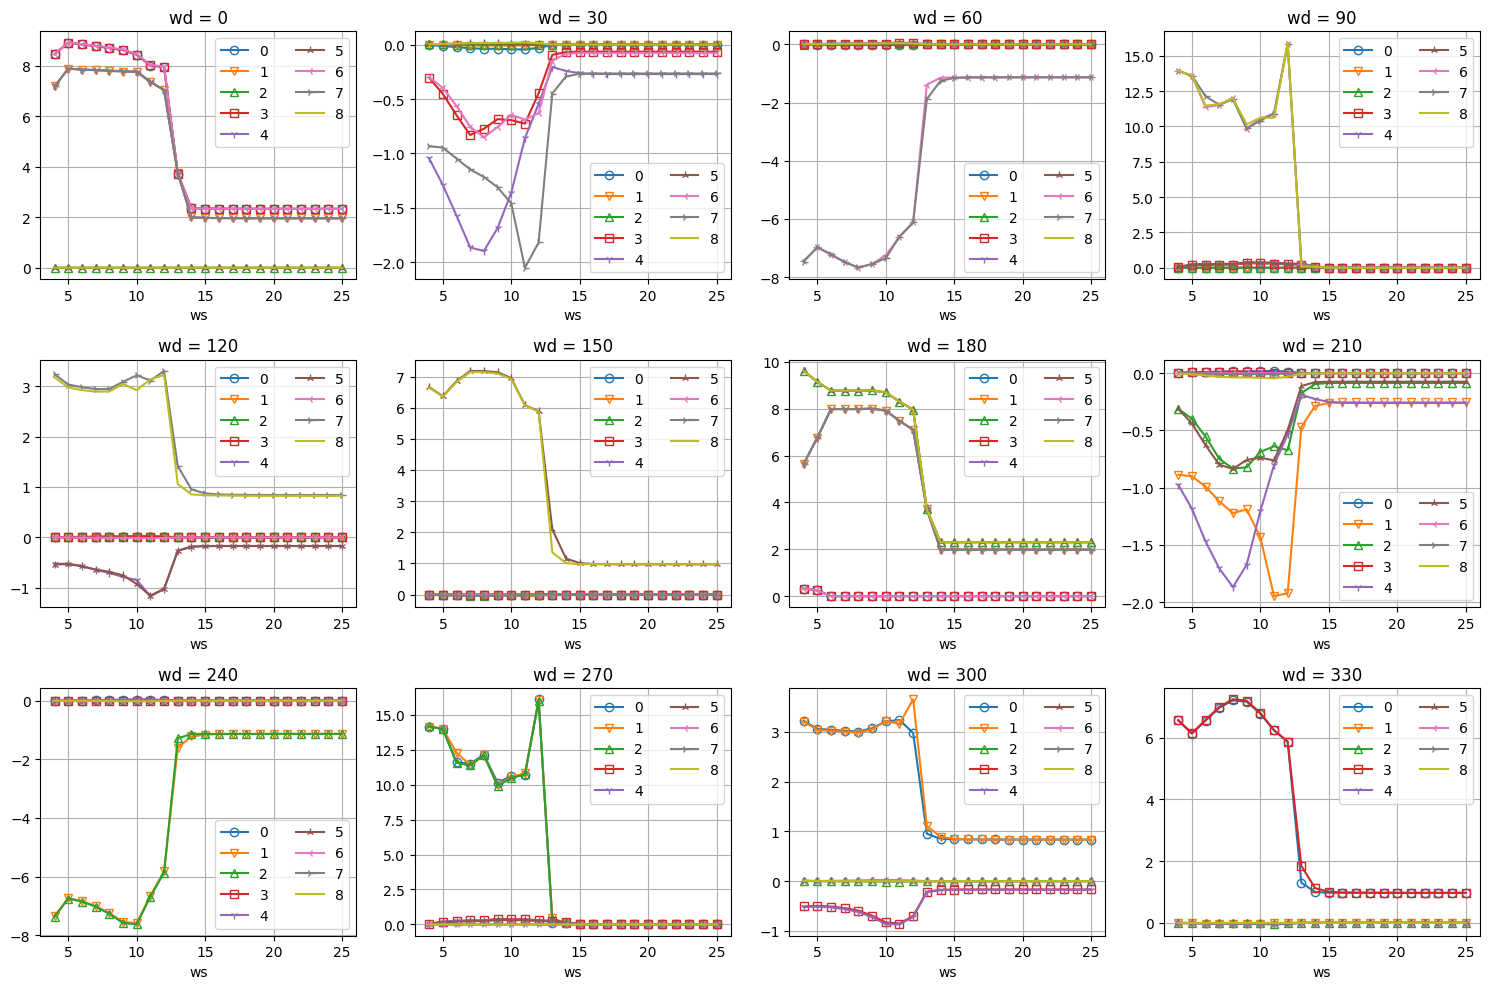

In [32]:
# plot optimal yaw values
fig, ax_all = plt.subplots(ncols=4, nrows=3, figsize=(15, 10))
for i, (wd_, ax) in enumerate(zip(yaw_opt.wd.values, ax_all.flatten())):
    yaw_opt.final.sel(wd=wd_).to_dataframe().pivot_table(
        values="final", index="ws", columns="wt"
    ).plot(ax=ax, fillstyle="none")
    for line, marker in zip(ax.get_lines(), ["o", "v", "^", "s", "1", "2", "3", "4"]):
        line.set_marker(marker)
    ax.set_title(f"wd = {wd_}")
    ax.grid()
    ax.legend(ncol=2)
fig.tight_layout()

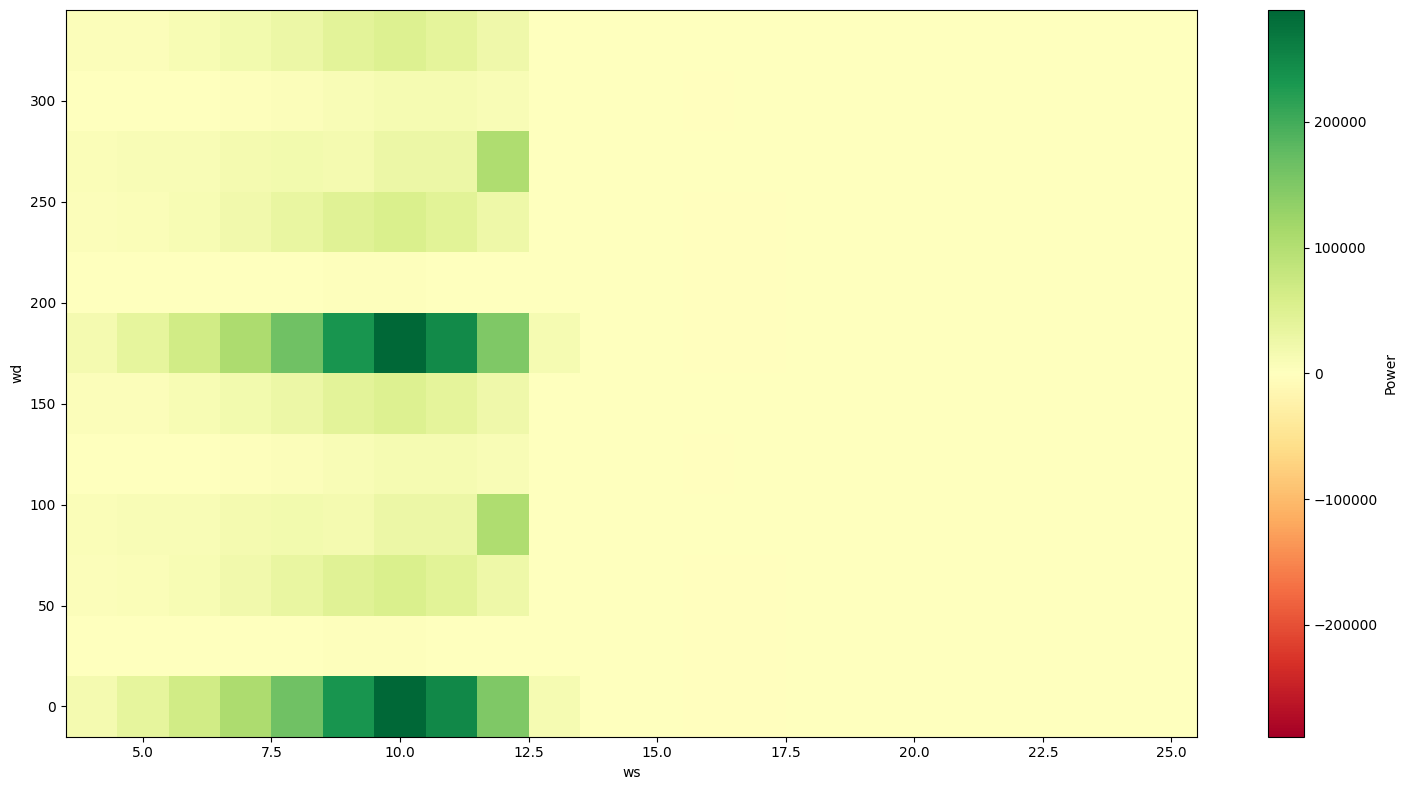

In [33]:
# plot change in wind farm power
power_delta = sim_res_opt.Power - sim_res_ref_high.Power
fig, ax = plt.subplots(figsize=(15, 8))
power_delta.sum("wt").plot(ax=ax, cmap="RdYlGn")
fig.tight_layout()

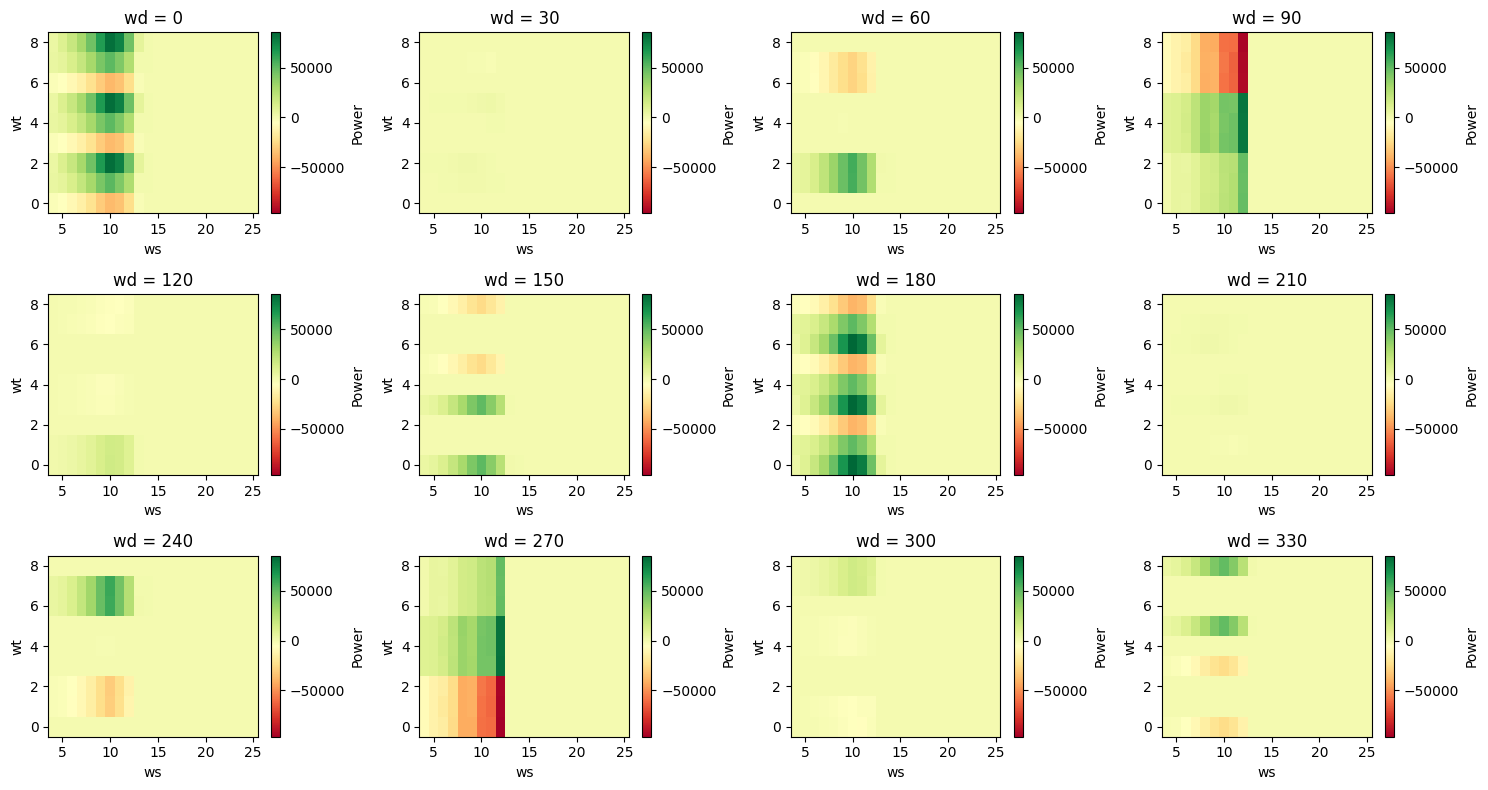

In [34]:
# plot change in individual wind turbine power
fig, ax_all = plt.subplots(ncols=4, nrows=3, figsize=(15, 8))
for i, (wd_, ax) in enumerate(zip(yaw_opt.wd.values, ax_all.flatten())):
    power_delta.sel(wd=wd_).plot(
        ax=ax, vmin=power_delta.min(), vmax=power_delta.max(), cmap="RdYlGn"
    )
fig.tight_layout()